# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 26

**Author 1 (sciper):** Andrea Oliveri (283506)  
**Author 2 (sciper):** Charles Berger (272018)   

**Release date:** 12.03.2021  
**Due date:** 26.03.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* Additional method of your choice (5 pts)

Each section should display the resulting segmenttion as well as the size in pixel of the detected region. Comment each method limitations and/or advantages.

### 1.1 Brain image visualization

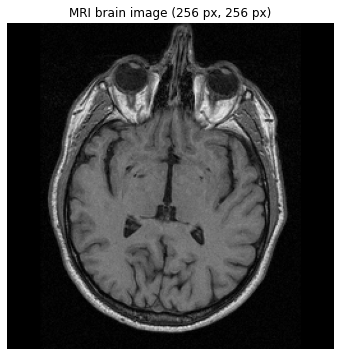

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing (5pts)

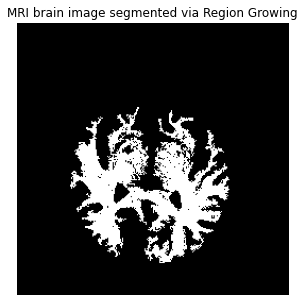

Number of pixels in brain: 8902


In [3]:
import cv2 as cv
import numpy as np

# Region Growing parameters.
seed     = (140, 140)
gray_thr = 25

# Segmenting.
close_pixels = np.abs(brain_im - brain_im[seed]) < gray_thr
_, segmented = cv.connectedComponents(close_pixels.astype(np.uint8))
mask         = segmented == segmented[seed]

# Display Segmentation Mask.
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(mask, cmap='gray')
ax.set_title('MRI brain image segmented via Region Growing')
ax.axis('off')
plt.show()

# Count number of pixels in brain.
print(f"Number of pixels in brain: {mask.sum()}")

Parler de comment seed a été choisie et comment threshold a ete determiné. Parler de bouts de cerveau pas segmenté dans image finale, problème est que sont entouré par des pixels pour foncés qui du coup separent certains bouts du bout principal (processus s'arrete sur le boundary noir)

DISCUSSION.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### 1.3 Contour detection (5pts)

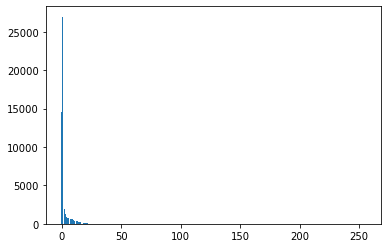

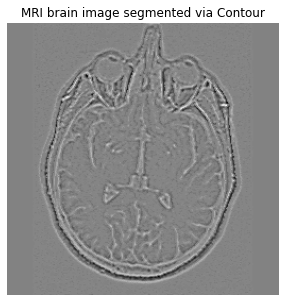

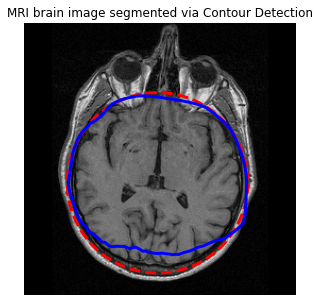

Number of pixels in brain: 8902


In [39]:
# Contour detection function
import scipy.ndimage as nd
import skimage.segmentation as seg
##
##Laplacian of gaussian :
 
Filtered_image= nd.gaussian_filter(brain_im,1)
LoG = cv.Laplacian(Filtered_image,ddepth = cv.CV_16S)
#LoG = nd.gaussian_laplace(brain_im,1.5)
##zero crossing factor : 
LoG[np.where(np.diff(np.sign(LoG)))] = 1
histogram, bin_edges = np.histogram(LoG, bins=256, range=(0, 256))
plt.bar(range(0,256), histogram)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(LoG, cmap='gray')
ax.set_title('MRI brain image segmented via Contour')
ax.axis('off')
plt.show()

##Image segmentation 

def circle_points(resolution,center,radius) : 
  
    #Generate Points which define a circle on an image, with its center o a position given 
    
    radians = np.linspace(0,2*np.pi,resolution)
    c = center[1] + radius*np.cos(radians)
    r = center[0] + radius*np.sin(radians)
    return np.array([c,r]).T
center = [150,125]
circle = circle_points(200,center,85)[:-1]
snake = seg.active_contour(brain_im, circle,alpha=0.06,beta=0.3,coordinates='rc')
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(brain_im, cmap='gray')   
ax.set_title('MRI brain image segmented via Contour Detection')
ax.axis('off')
ax.plot(circle[:,0],circle[:,1],'--r',lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);
plt.show()

#_, segmented = cv.connectedComponents(LoG.astype(np.uint8))
#mask         = segmented == segmented[seed]

# Display Segmentation Mask.


# Count number of pixels in brain.
print(f"Number of pixels in brain: {mask.sum()}")

DISCUSSION.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### 1.4 Additional method (5pts)

<BarContainer object of 256 artists>

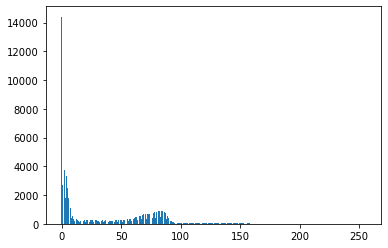

In [34]:
histogram, bin_edges = np.histogram(brain_im, bins=256, range=(0, 256))
plt.bar(range(0,256), histogram)


DISCUSSION.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

### 2.1 Visualization

In [6]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


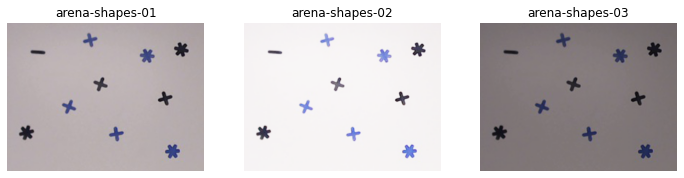

In [7]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

In [8]:
# Add your implementation and discussion

### 2.3 Total area (in pixels) of each color (5 pts)

In [9]:
# Add your implementation and discussion